In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import captum
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=3, ax=None, **kwargs):
    pos = points.mean(axis=0)     ## center of ellipse
    cov = np.cov(points, rowvar=False)  ## cov
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)
 
def plot_cov_ellipse(cov, pos, nstd=3, ax=None, **kwargs):
    def eigsorted(cov):
        cov = np.array(cov)
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
 
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellip)
    return ellip


def plot_A_B_line(Ax,Ay,Bx,By):
    x = np.linspace(Ax, Bx, 100)
    y = np.linspace(Ay, By, 100)
    plt.plot(x, y, 'b-', linewidth=2)

## Data

Link: https://www.ebi.ac.uk/biostudies/studies/S-BSST843?query=S-BSST843

Scale to [0,1] by sample(row), as perhaps measurement is not quantative

But why the original matrix get df[proteins].min().min() == -2.72892 ??   --- is it logged already?

In [2]:
TimeLine = ['PND1', 'PND3', 'PND7', 'PND14', 'PNW4', 'PMW30', 'PMW32', 'PMW36', 'PMW40']

def getTimeLine(sampleID):
    return TimeLine.index(sampleID.split('_')[0])

In [3]:
df = pd.read_csv('Preterm_sample_Olink.txt', sep='\t')
df.fillna(0, inplace=True)
df['TimeLine'] = df['sampleID'].apply(lambda x : getTimeLine(x))
proteins = df.columns[4:-1].tolist()

scaler = MinMaxScaler()
df[proteins] = scaler.fit_transform(df[proteins].T).T
# df.iloc[:5, :8]

## 1.1 AE: Embed the Protein Profile --- No constrain

In [4]:
data_tensor = torch.tensor(df[proteins].values.astype(np.float32))  ## torch.Size([1335, 538])

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # activate to [0, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = len(proteins) 
hidden_dim = 100 
autoencoder = Autoencoder(input_dim, hidden_dim)
criterion = nn.MSELoss() 
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    reconstructed = autoencoder(data_tensor)
    loss = criterion(reconstructed, data_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch +1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0051
Epoch [20/100], Loss: 0.0034
Epoch [30/100], Loss: 0.0035
Epoch [40/100], Loss: 0.0030
Epoch [50/100], Loss: 0.0028
Epoch [60/100], Loss: 0.0027
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0024
Epoch [90/100], Loss: 0.0023
Epoch [100/100], Loss: 0.0022


In [5]:
encoder = autoencoder.encoder
encoded_data = encoder(data_tensor)

non_zero_dim = sum(encoded_data != 0).nonzero().flatten()

## 1.2 Plot the embedding 

on the top distant dim

1. Compare between each successive group ---- obviously there's a patteren folowing the TimeLine
2. Compare between other labels shows no obvious pattern..? same as in paper

In [6]:
dims = ['Dim_{}'.format(i) for i in range(hidden_dim)]
encoded_df = pd.DataFrame( encoded_data.detach().numpy() , columns=dims)
encoded_df['TimeLine'] = df['TimeLine'].copy()
encoded_df['delivery'] = df['delivery'].copy()
encoded_df['Gender'] = df['Gender'].copy()
encoded_df['GA_group'] = df['GA_group'].str.split(' ',expand = True)[2].astype(int) -1

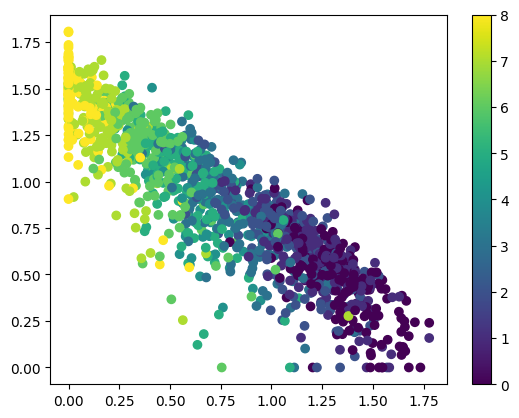

In [7]:
distance = 0
for i in range(8):
    c1 = encoded_df.groupby('TimeLine').get_group(i)[dims]
    c2 = encoded_df.groupby('TimeLine').get_group(i+1)[dims]
    distance = distance + abs(c1.mean() - c2.mean()) 

dim_rank1 = distance.idxmax()
dim_rank2 = distance.drop(dim_rank1).idxmax()
plt.scatter(encoded_df[dim_rank1], encoded_df[dim_rank2], c=encoded_df['TimeLine'], cmap='viridis')
plt.colorbar()

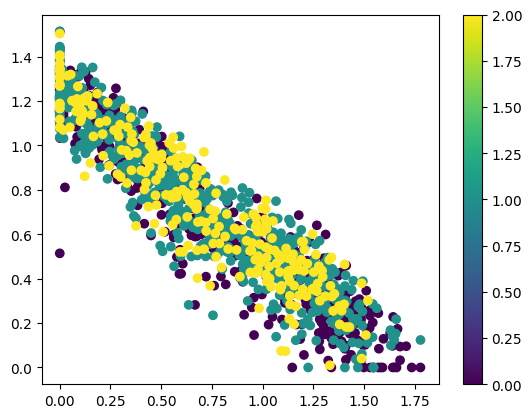

In [8]:
distance = 0
for i in range(2):
    c1 = encoded_df.groupby('GA_group').get_group(i)[dims]
    c2 = encoded_df.groupby('GA_group').get_group(i+1)[dims]
    distance = distance + abs(c1.mean() - c2.mean()) 

dim_rank1 = distance.idxmax()
dim_rank2 = distance.drop(dim_rank1).idxmax()
plt.scatter(encoded_df[dim_rank1], encoded_df[dim_rank2], c=encoded_df['GA_group'], cmap='viridis')
plt.colorbar()

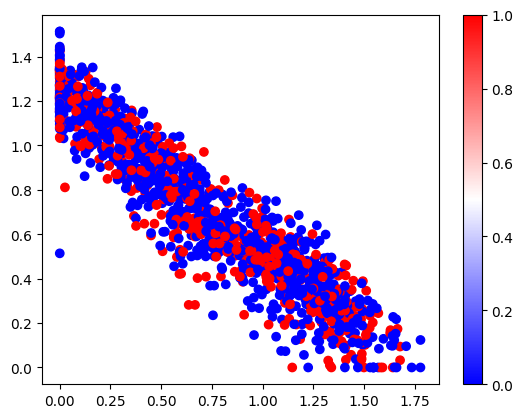

In [9]:
c1 = encoded_df.groupby('delivery').get_group('C_section')[dims]
c2 = encoded_df.groupby('delivery').get_group('Vaginal')[dims]
distance = distance + abs(c1.mean() - c2.mean()) 

dim_rank1 = distance.idxmax()
dim_rank2 = distance.drop(dim_rank1).idxmax()
plt.scatter(encoded_df[dim_rank1], encoded_df[dim_rank2], c=encoded_df['delivery'] == 'Vaginal', cmap='bwr')
plt.colorbar()

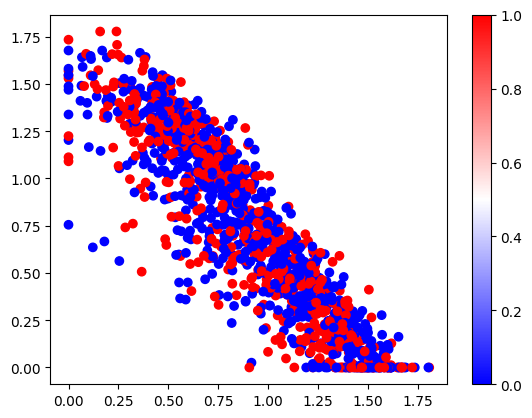

In [10]:
c1 = encoded_df.groupby('Gender').get_group('female')[dims]
c2 = encoded_df.groupby('Gender').get_group('male')[dims]
distance = distance + abs(c1.mean() - c2.mean()) 

dim_rank1 = distance.idxmax()
dim_rank2 = distance.drop(dim_rank1).idxmax()
plt.scatter(encoded_df[dim_rank1], encoded_df[dim_rank2], c=encoded_df['Gender'] == 'female', cmap='bwr')
plt.colorbar()

In [11]:
label_tensor = torch.tensor(    df['Gender'].map(lambda x: 1 if x=='female' else 0).values.astype(np.float32)   ).unsqueeze(1)
label_tensor.shape

torch.Size([1335, 1])

## 2.1 Classifier: Embed the Protein Profile --- Constrain on Gender

In [12]:
data_tensor = torch.tensor(df[proteins].values.astype(np.float32))
# label_tensor = torch.tensor(    df['Gender'].map(lambda x: '1_0' if x=='female' else '0_1').str.split('_',expand=True).values.astype(np.float32)   )
label_tensor = torch.tensor(    df['Gender'].map(lambda x: 1 if x=='female' else 0).values.astype(np.float32)   ).unsqueeze(1)


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # activate to [0, 1]
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = len(proteins) 
hidden_dim = 100 
classifier_model = Classifier(input_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)


num_epochs = 2000
for epoch in range(num_epochs):
    pred = classifier_model(data_tensor)
    loss = criterion(pred, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch +1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 0.6394
Epoch [200/2000], Loss: 0.5126
Epoch [300/2000], Loss: 0.4217
Epoch [400/2000], Loss: 0.3607
Epoch [500/2000], Loss: 0.3180
Epoch [600/2000], Loss: 0.2852
Epoch [700/2000], Loss: 0.2722
Epoch [800/2000], Loss: 0.2387
Epoch [900/2000], Loss: 0.2212
Epoch [1000/2000], Loss: 0.2051
Epoch [1100/2000], Loss: 0.1916
Epoch [1200/2000], Loss: 0.1797
Epoch [1300/2000], Loss: 0.1725
Epoch [1400/2000], Loss: 0.1596
Epoch [1500/2000], Loss: 0.1507
Epoch [1600/2000], Loss: 0.1433
Epoch [1700/2000], Loss: 0.1362
Epoch [1800/2000], Loss: 0.1293
Epoch [1900/2000], Loss: 0.1240
Epoch [2000/2000], Loss: 0.1184


In [13]:
encoder = classifier_model.encoder
encoded_data = encoder(data_tensor)

non_zero_dim = sum(encoded_data != 0).nonzero().flatten()

## 1.2 Plot the embedding 

gender info seems included in protein profile --- next to explain it

Draw Eclips: https://blog.csdn.net/ThePaK/article/details/129323910


In [14]:
dims = ['Dim_{}'.format(i) for i in range(hidden_dim)]
encoded_df = pd.DataFrame( encoded_data.detach().numpy() , columns=dims)
encoded_df['TimeLine'] = df['TimeLine'].copy()
encoded_df['delivery'] = df['delivery'].copy()
encoded_df['Gender'] = df['Gender'].copy()
encoded_df['GA_group'] = df['GA_group'].str.split(' ',expand = True)[2].astype(int) -1

C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\patches.py:1567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


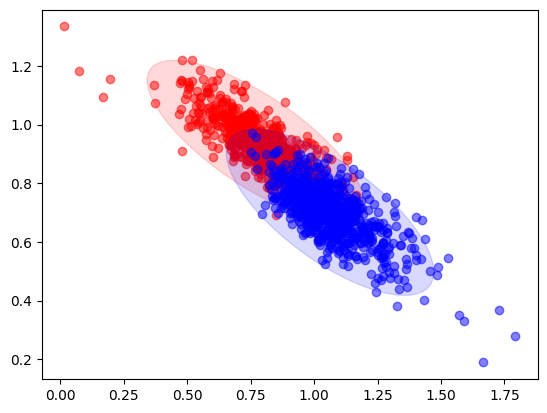

In [15]:
c1 = encoded_df.groupby('Gender').get_group('female')[dims]
c2 = encoded_df.groupby('Gender').get_group('male')[dims]
distance = abs(c1.mean() - c2.mean()) 
# var = c1.var() + c2.var()

dim_rank1 = distance.idxmax()
dim_rank2 = distance.drop(dim_rank1).idxmax()
# var_rank1 = var.idxmax()

for c,color in zip([c1, c2],['red','blue']):
    plt.scatter(c[dim_rank1], c[dim_rank2], color=color, alpha = 0.5)
    plot_point_cov(c[[dim_rank1,dim_rank2]], nstd=3, alpha=0.15, color=color)


## 1.3 Captum -- Explain Model

[Guide](https://pytorch.ac.cn/tutorials/beginner/introyt/captumyt.html#feature-attribution-with-integrated-gradients)

or [SHAP's DeepExplainer/KernelExplainer](https://geek-docs.com/pytorch/pytorch-questions/262_pytorch_shap_values_with_pytorch_kernelexplainer_vs_deepexplainer.html)


XAI Not so sure about the explaination ...  but plot shows importance rank of each attribute are consistant in the 2 groups 


And as the encoder is a linear model, perhaps I can use its weight

Gender,female,male,gap,sum
CGA,484.862396,62.411877,422.450531,547.274292
XG,463.196259,62.418690,400.777557,525.614929
MBL2,300.216217,60.650299,239.565918,360.866516
FCRL1,294.336609,60.734894,233.601715,355.071503
SPINK1,292.991364,60.479408,232.511963,353.470764
...,...,...,...,...
CCL23,-58.633522,-308.573334,249.939819,-367.206848
CCL19,-59.078327,-319.939178,260.860840,-379.017517
TPP1,-59.537323,-343.535522,283.998199,-403.072845
CCL17,-60.811535,-417.182617,356.371094,-477.994141


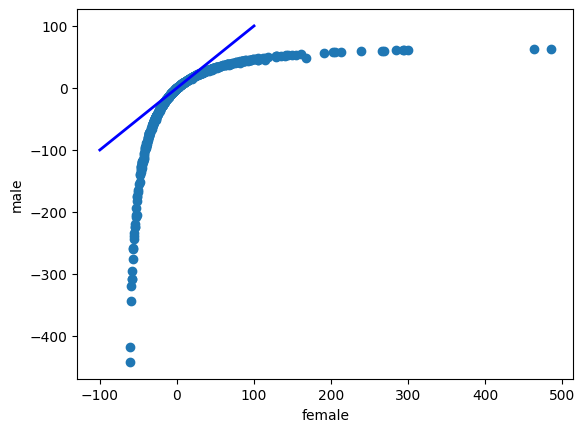

In [16]:
from captum.attr import IntegratedGradients
from captum.attr import Occlusion

# classifier_model.eval() 
# ig = IntegratedGradients(classifier_model)
# attributions, delta = ig.attribute(data_tensor, target=0, return_convergence_delta=True)    ## target: indexlist of output dim, thiscase:only one


classifier_model.eval() 
occlusion = Occlusion(classifier_model)
attributions = occlusion.attribute(data_tensor, sliding_window_shapes=(1,), target=0)  ## At dim0: female=1
                                         ## Attribut to perdict dim0 as 1??? I think its just attribut to this dim


attributions_df = pd.DataFrame( attributions.detach().numpy() , columns=proteins)
attributions_df['Gender'] = df['Gender'].copy()
attributions_df = attributions_df.groupby('Gender').sum().T
attributions_df['gap'] = attributions_df['female'] - attributions_df['male']
attributions_df['sum'] = attributions_df['female'] + attributions_df['male']

plt.scatter(attributions_df['female'], attributions_df['male'])
plot_A_B_line(-100,-100,100,100)
plt.xlabel('female')
plt.ylabel('male')

attributions_df[attributions_df['male'] > -np.inf].sort_values(by='sum', ascending=False)

In [17]:
set(attributions_df.sort_values(by='male', ascending=False).index[:10]) 

{'CDON',
 'CGA',
 'CXCL11',
 'FCRL1',
 'FGF-19',
 'MBL2',
 'NID2',
 'PRSS27',
 'SPINK1',
 'XG'}

In [18]:
set(attributions_df.sort_values(by='female', ascending=False).index[:10])

{'CDON',
 'CGA',
 'CXCL11',
 'FCRL1',
 'FGF-19',
 'MBL2',
 'NID2',
 'PRSS27',
 'SPINK1',
 'XG'}

In [19]:
topdim_weight = classifier_model.state_dict()['encoder.0.weight'][int(dim_rank1.split('_')[1])].numpy()

topdim_arg_ranks_df = pd.DataFrame({
'proteins' : proteins,
'weight' : topdim_weight,
'weightRank' : np.argsort(abs(topdim_weight))
})


topdim_arg_ranks_df.sort_values(by='weightRank', ascending=False)[:10]

,proteins,weight,weightRank
536,XCL1,-0.105416,537
307,LILRA5,-0.092042,536
356,NOV,-0.048651,535
280,IL5,0.039284,534
195,FCRL5,-0.153108,533
347,NADK,0.021226,532
406,PRSS27,-0.193482,531
91,CD6,0.062268,530
429,S100P,-0.068139,529
293,KIM1,-0.077571,528


## 1.4 See the Top10 attributed Protein

```
['CGA',        Glycoprotein Hormones  --- glycoprotein hormones
 'XG',         Glycoprotein --- on the short (p) arm of chromosome X
 'SPINK1',     trypsin inhibitor --- digestion / related pathways is Androgen receptor network in prostate cancer
 'FCRL1',      Fc Receptor --- immune
 'MBL2',       --- immune system
 'FGF-19',     fibroblast growth --- development
 'NID2',       basement membrane proteins
 'CXCL11',     --- regulate cell trafficking of various types of leukocytes
 'PRSS27',     --- tryptic serine
 'CDON']       --- cell-cell interactions between muscle precursor cells
```

https://www.genecards.org/cgi-bin/carddisp.pl?gene=XG